In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import random
import scipy.stats as stats

In [2]:
# load data: https://www.kaggle.com/datasets/tejashvi14/medical-insurance-premium-prediction?select=Medicalpremium.csv
# data set to predict insurance premium based on demographic/health/other factors.
data = pd.read_csv("../AB/Medicalpremium.csv")
print(data.shape)
data.head()

(986, 11)


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [10]:
# separate outcome and predictors, and scale predictors before model fitting
from sklearn.preprocessing import StandardScaler
colnames = list(data)
X = data[colnames[:-1]]
#Xsc = StandardScaler().fit_transform(X)
y = data[colnames[-1]]
#Xsc

In [18]:
# split data into train and test set
# test data, once we get a model to have good test evaluation scores, will be used to simulate ab test data
test_percentage = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, random_state=1)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
len(y_train), len(y_test), X_train.shape, X_test.shape

(788, 198, (788, 10), (198, 10))

In [12]:
# fix high learning rate to find optimal number of estimators
# tune n_estimators first, then max_depth and min_child_weight together
# too high of run time if searching through all params at once. use greedy approach
# if only single value of param is listed, it means those are the optimal values for the parameters, 
# found through iterative search
params=[{'n_estimators': [48,49,50,51,52], 'max_depth': [3,4,5,6,7], 'min_child_weight':[1]}]
xgb1 = XGBRegressor(learning_rate =0.1, subsample=0.8, 
                    colsample_bytree=0.8, scale_pos_weight=1, seed=1)
gs1 = GridSearchCV(xgb1, param_grid = params, scoring='neg_mean_squared_error',cv = 10)
gs1.fit(X_train,y_train)
gs1.best_params_

{'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 49}

In [13]:
# total mean sum of squares
tmss = np.mean(np.power(y_train - np.mean(y_train),2))
# mean squared error relative to total mean sum of squares
-gs1.score(X_train,y_train)/tmss
metrics.r2_score(gs1.predict(X_train), y_train)

0.9567554235759512

In [14]:
# test error rate
metrics.r2_score(gs1.predict(X_test),y_test)

0.5628195587984146

In [22]:
m = X_test.mean(axis=0)
X_test - m, X_test, m

(array([[19.98989899,  0.53535354,  0.5       , ..., -0.23232323,
         -0.09090909,  2.34343434],
        [-8.01010101, -0.46464646,  0.5       , ..., -0.23232323,
         -0.09090909, -0.65656566],
        [14.98989899,  0.53535354, -0.5       , ..., -0.23232323,
         -0.09090909, -0.65656566],
        ...,
        [ 3.98989899,  0.53535354,  0.5       , ...,  0.76767677,
         -0.09090909,  0.34343434],
        [-6.01010101, -0.46464646, -0.5       , ...,  0.76767677,
         -0.09090909, -0.65656566],
        [15.98989899,  0.53535354,  0.5       , ..., -0.23232323,
         -0.09090909,  0.34343434]]),
 array([[63,  1,  1, ...,  0,  0,  3],
        [35,  0,  1, ...,  0,  0,  0],
        [58,  1,  0, ...,  0,  0,  0],
        ...,
        [47,  1,  1, ...,  1,  0,  1],
        [37,  0,  0, ...,  1,  0,  0],
        [59,  1,  1, ...,  0,  0,  1]], dtype=int64),
 array([4.30101010e+01, 4.64646465e-01, 5.00000000e-01, 8.58585859e-02,
        1.96969697e-01, 1.68151515e+02,

- Need a way to generate a sample of predictions to calculate variance in predictions
- incorporate this variance to treatment effect estimator variance calculation

In [51]:
# without considering variance in model

# assume you are randomly assigning incoming stream of observations to treatment or control
# each observation in the stream is randomly chosen with replacement from the remaining data (X_ab, y_ab)
# if treatment, add constant te to y_ab, otherwise leave it

random.seed(1)
np.random.seed(1)
# treatment effect (constant)
te = 3000
sim_num = 10000
temp = []
n1 = n0 = 400
indx_range = range(0,len(y_test))
predictions = gs1.predict(X_test)
for i in range(sim_num):
    control_idx = random.choices(indx_range, k=n0)
    treat_idx = random.choices(indx_range, k=n1)
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te

    # perform difference in means
    two_est = np.mean(treat_y) - np.mean(control_y)
    two_se = (np.var(treat_y,ddof=1)/n1 + np.var(control_y,ddof=1)/n0)**0.5
    
    # perform counterfactual estimator with regression
    # first need to get mean centered matrices
    control_x_c = control_x - control_x.mean(axis=0)
    treat_x_c = treat_x - treat_x.mean(axis=0)
    control_y_c = control_y - control_y.mean()
    treat_y_c = treat_y - treat_y.mean()
    treatxvar = np.matmul(np.transpose(treat_x_c), treat_x_c)
    controlxvar = np.matmul(np.transpose(control_x_c), control_x_c)
    treatxcov = np.matmul(np.transpose(treat_x_c),treat_y_c)
    controlxcov = np.matmul(np.transpose(control_x_c),control_y_c)
    # use try except to check for invertibility in np.linalg.inv
    # dont use while loop, would have to take a different sample from above and start the last two estimates over again
    try:
        denom = np.linalg.inv(treatxvar + controlxvar)
    except:
        continue
    beta = np.matmul(denom,treatxcov + controlxcov)
    #print(treat_x.shape, beta.shape)
    alpha1 = np.mean(treat_y) - np.dot(treat_x.mean(axis=0),beta)
    alpha0 = np.mean(control_y) - np.dot(control_x.mean(axis=0),beta)
    reg_est = alpha1 - alpha0
    reg_se = (np.var(treat_y - np.matmul(treat_x,beta),ddof=1)/n1 + np.var(control_y - np.matmul(control_x,beta),ddof=1)/n0)**0.5
    
    # perform counterfactual estimator with ML
    treat_preds = predictions[treat_idx]
    control_preds = predictions[control_idx]
    pred_alpha1 = np.mean(treat_y - treat_preds)
    pred_alpha0 = np.mean(control_y - control_preds)
    ml_est = pred_alpha1 - pred_alpha0
    ml_se = (np.var(treat_y - treat_preds,ddof=1)/n1 + np.var(control_y - control_preds,ddof=1)/n0)**0.5

    #perform secondary linear adjustment to ML
    control_r = control_y - control_preds
    treat_r = treat_y - treat_preds
    treat_r_c = treat_r - treat_r.mean()
    control_r_c = control_r - control_r.mean()
    treatxcovr = np.matmul(np.transpose(treat_x_c),treat_r_c)
    controlxcovr = np.matmul(np.transpose(control_x_c),control_r_c)
    beta_s = np.matmul(denom,treatxcovr + controlxcovr)
    alpha1_s = np.mean(treat_r) - np.dot(treat_x.mean(axis=0),beta_s)
    alpha0_s = np.mean(control_r) - np.dot(control_x.mean(axis=0),beta_s)
    s_est = alpha1_s - alpha0_s
    s_se = (np.var(treat_r - np.matmul(treat_x,beta_s),ddof=1)/n1 + np.var(control_r - np.matmul(control_x,beta_s),ddof=1)/n0)**0.5

    # append results
    temp.append([two_est, two_se, reg_est, reg_se, ml_est, ml_se, s_est, s_se, beta, beta_s])
    
sim_res = pd.DataFrame(temp, columns = ['two_est','two_se','reg_est','reg_se','ml_est','ml_se','s_est','s_se','beta','beta_s'])


In [56]:
sim_res.describe()

,two_est,two_se,reg_est,reg_se,ml_est,ml_se,s_est,s_se
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3000.819000,450.043572,3000.715451,271.914080,2998.194674,257.473821,2998.428277,251.041034
std,448.241609,10.136428,278.611297,14.011217,258.684500,20.370239,255.646910,20.540142
min,1350.000000,409.857986,1953.493644,215.807122,2035.911780,180.107642,2074.713358,173.193530
25%,2700.000000,443.162920,2811.298135,262.319615,2823.537986,243.630509,2825.005914,237.018194
50%,3002.500000,450.175778,3000.165718,271.748799,2998.898838,257.236307,2999.496042,250.980683
75%,3307.500000,456.980220,3192.097517,281.110311,3171.157277,271.394000,3167.076728,264.945930
max,4617.500000,489.494634,4270.128166,327.490727,3908.002412,340.699323,3876.661589,334.724458


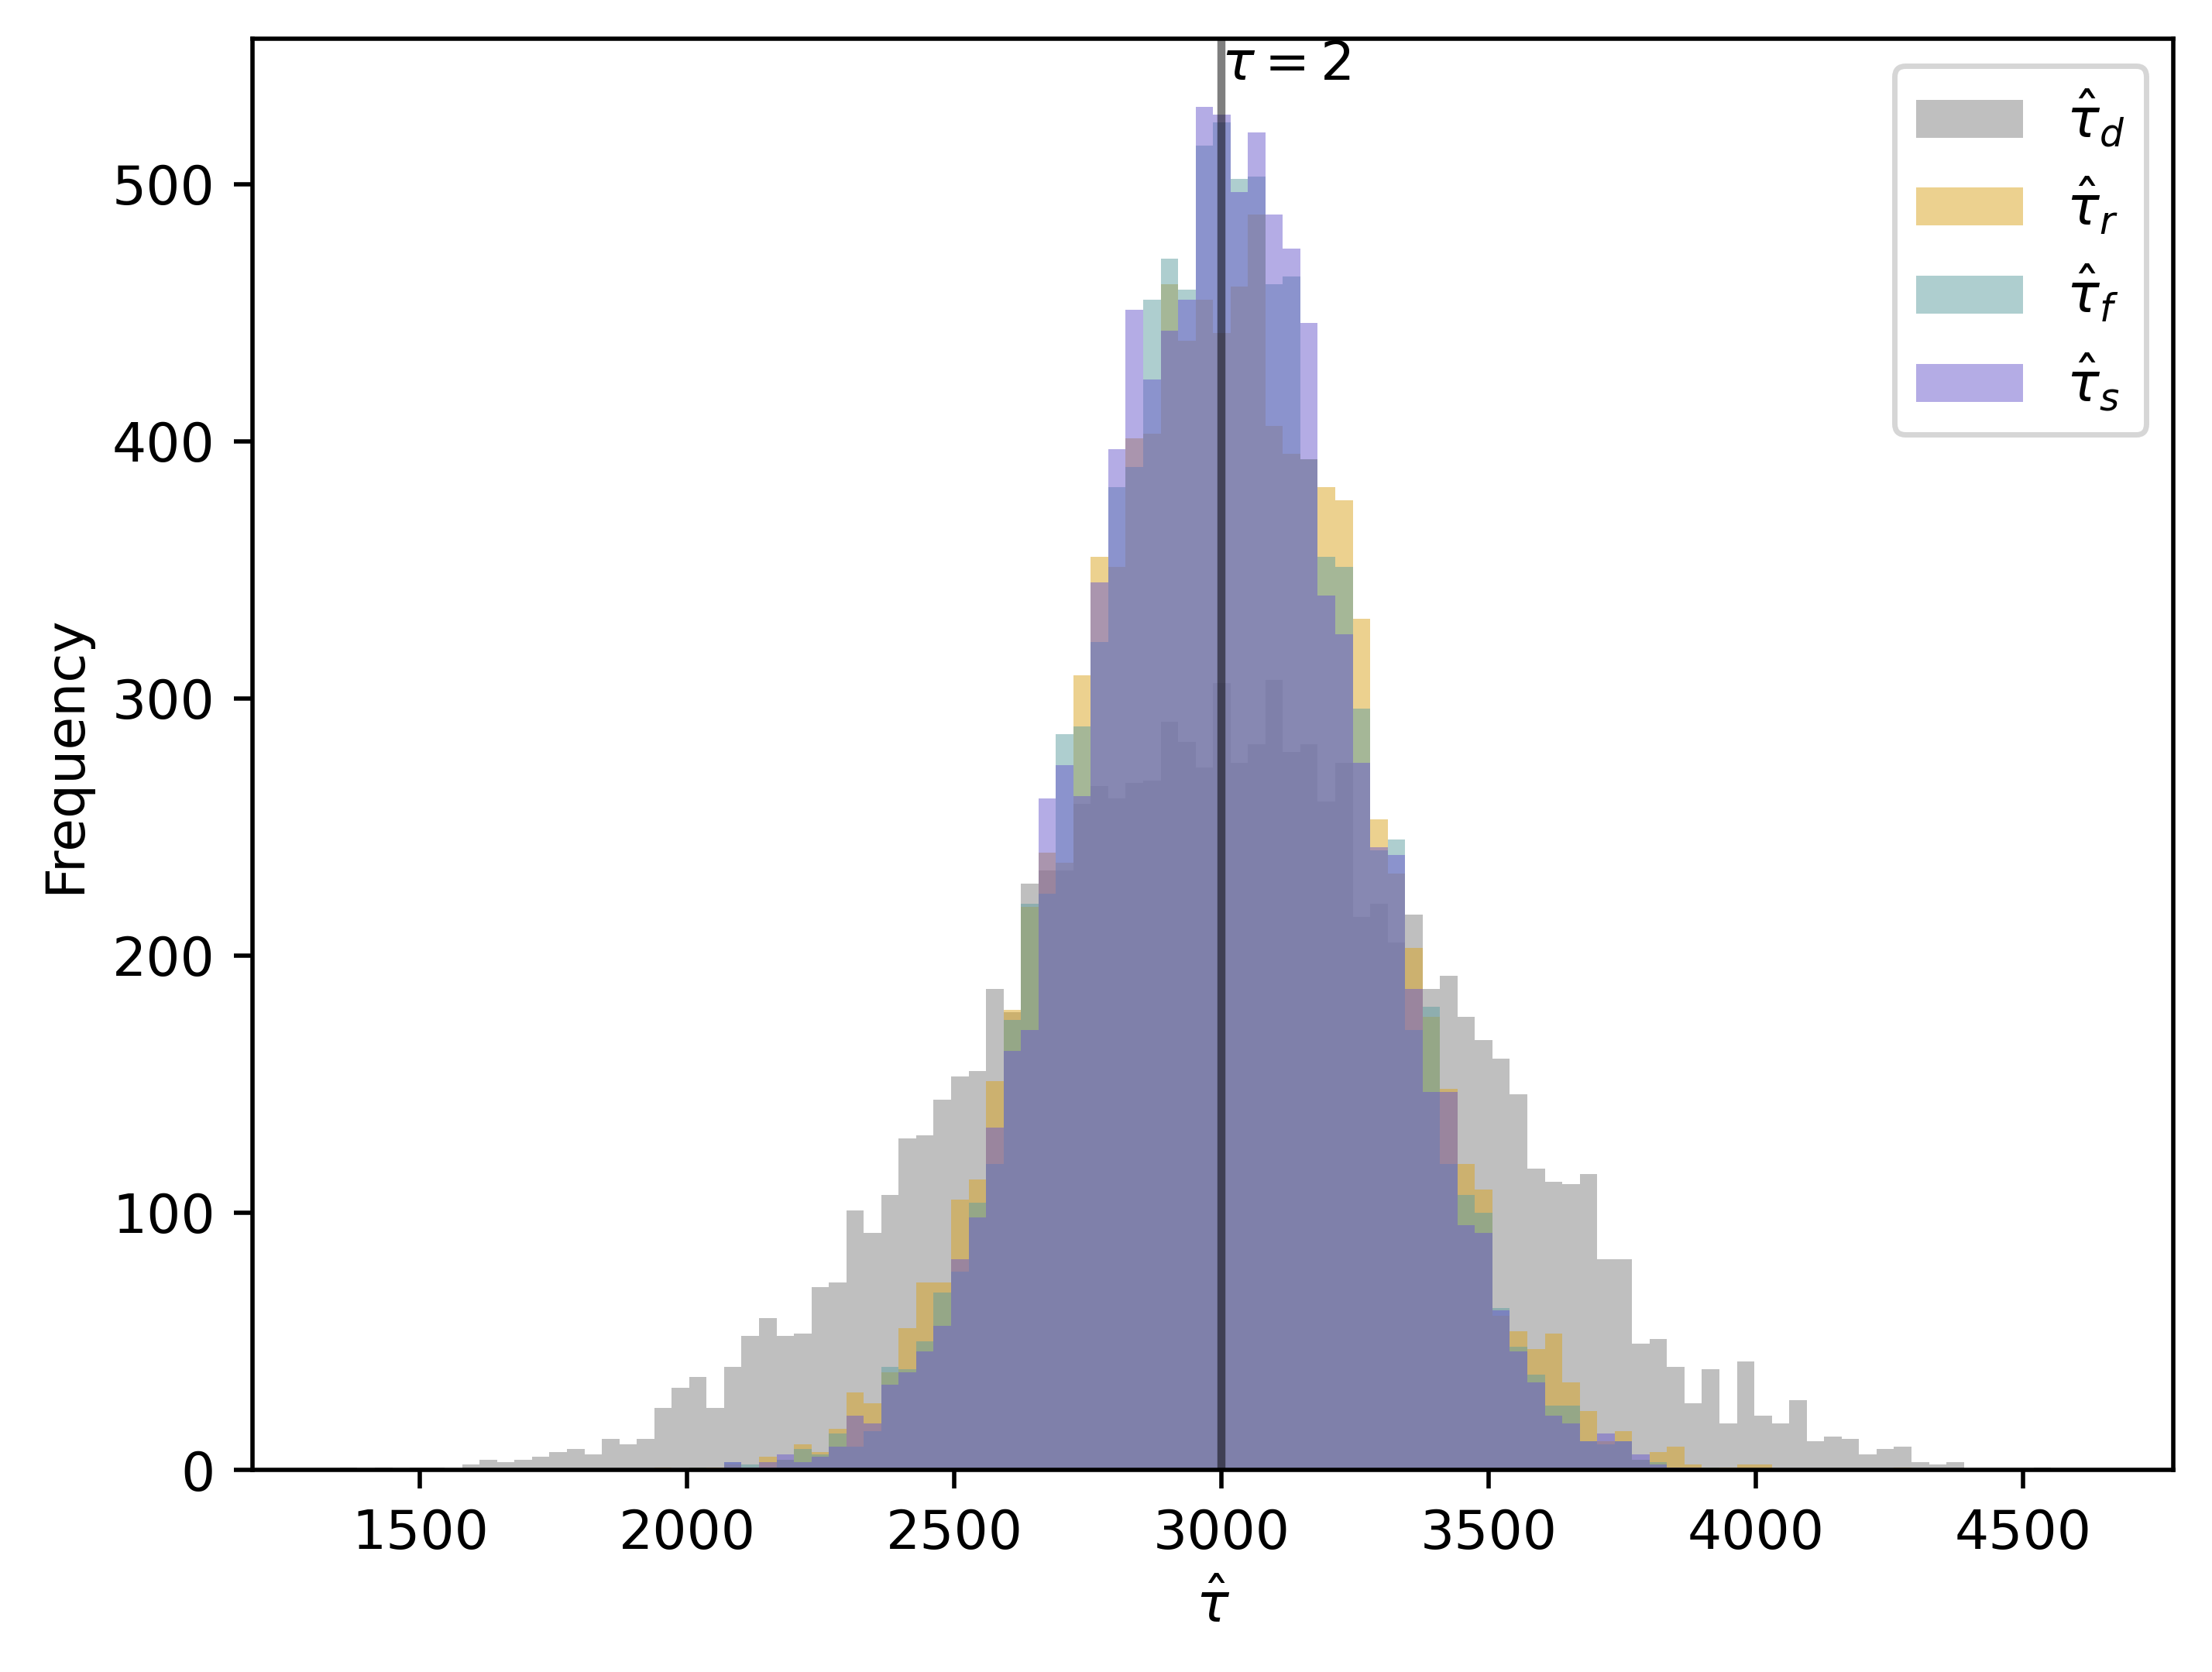

Sample size: 400 ATE_d: 3000.819 ATE_r: 3000.7154505428152 ATE_ml: 2998.194673565918 ATE_s: 2998.428277026291
Var_d: 200920.54004300432 Var_red_r: 0.613656945942988 Var_red_ml:  0.6669446002356759 Var__red_s: 0.6747204510926369


In [49]:
colors = {'two': 'gray', 'reg': 'goldenrod', 'ml': 'cadetblue', 'mix': 'slateblue'}
dpi = 500
plt.figure(dpi=dpi)
# use this to first determine overall range, and manually set max and min with visual analysis
bins_max = max(max(sim_res['two_est']),max(sim_res['reg_est']),max(sim_res['ml_est']),max(sim_res['s_est']))
bins_min = min(min(sim_res['two_est']),min(sim_res['reg_est']),min(sim_res['ml_est']),min(sim_res['s_est']))
#bins_max = 7
#bins_min = -3
bins_freq = 100
bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
plt.hist(sim_res['two_est'], bins = bins_range, color = colors['two'], label = r"$\hat{\tau}_d$", alpha=0.5)
plt.hist(sim_res['reg_est'], bins = bins_range, color = colors['reg'], label=r"$\hat{\tau}_r$",alpha=0.5)
plt.hist(sim_res['ml_est'], bins = bins_range, color = colors['ml'], label=r"$\hat{\tau}_{f}$",alpha=0.5)
plt.hist(sim_res['s_est'], bins = bins_range, color = colors['mix'], label=r"$\hat{\tau}_{s}$",alpha=0.5)
top_loc = plt.gca().get_ylim()[1]
plt.text(te, top_loc, r"$\tau = 2$",verticalalignment='top')
plt.axvline(te, color = 'black', linestyle='-',alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel(r"$\hat{\tau}$")
plt.legend(loc=1)
#plt.savefig("plots/sec_" + str(key) + "_ate.png")
plt.show()
print("Sample size:",n1, "ATE_d:", np.mean(sim_res['two_est']), "ATE_r:", 
      np.mean(sim_res['reg_est']),"ATE_ml:",np.mean(sim_res['ml_est']),"ATE_s:",np.mean(sim_res['s_est']))
print("Var_d:", np.var(sim_res['two_est'],ddof=1), "Var_red_r:", 1-np.var(sim_res['reg_est'],ddof=1)/np.var(sim_res['two_est'],ddof=1),
  "Var_red_ml: ", 1-np.var(sim_res['ml_est'],ddof=1)/np.var(sim_res['two_est'],ddof=1),
  "Var__red_s:", 1-np.var(sim_res['s_est'],ddof=1)/np.var(sim_res['two_est'],ddof=1))

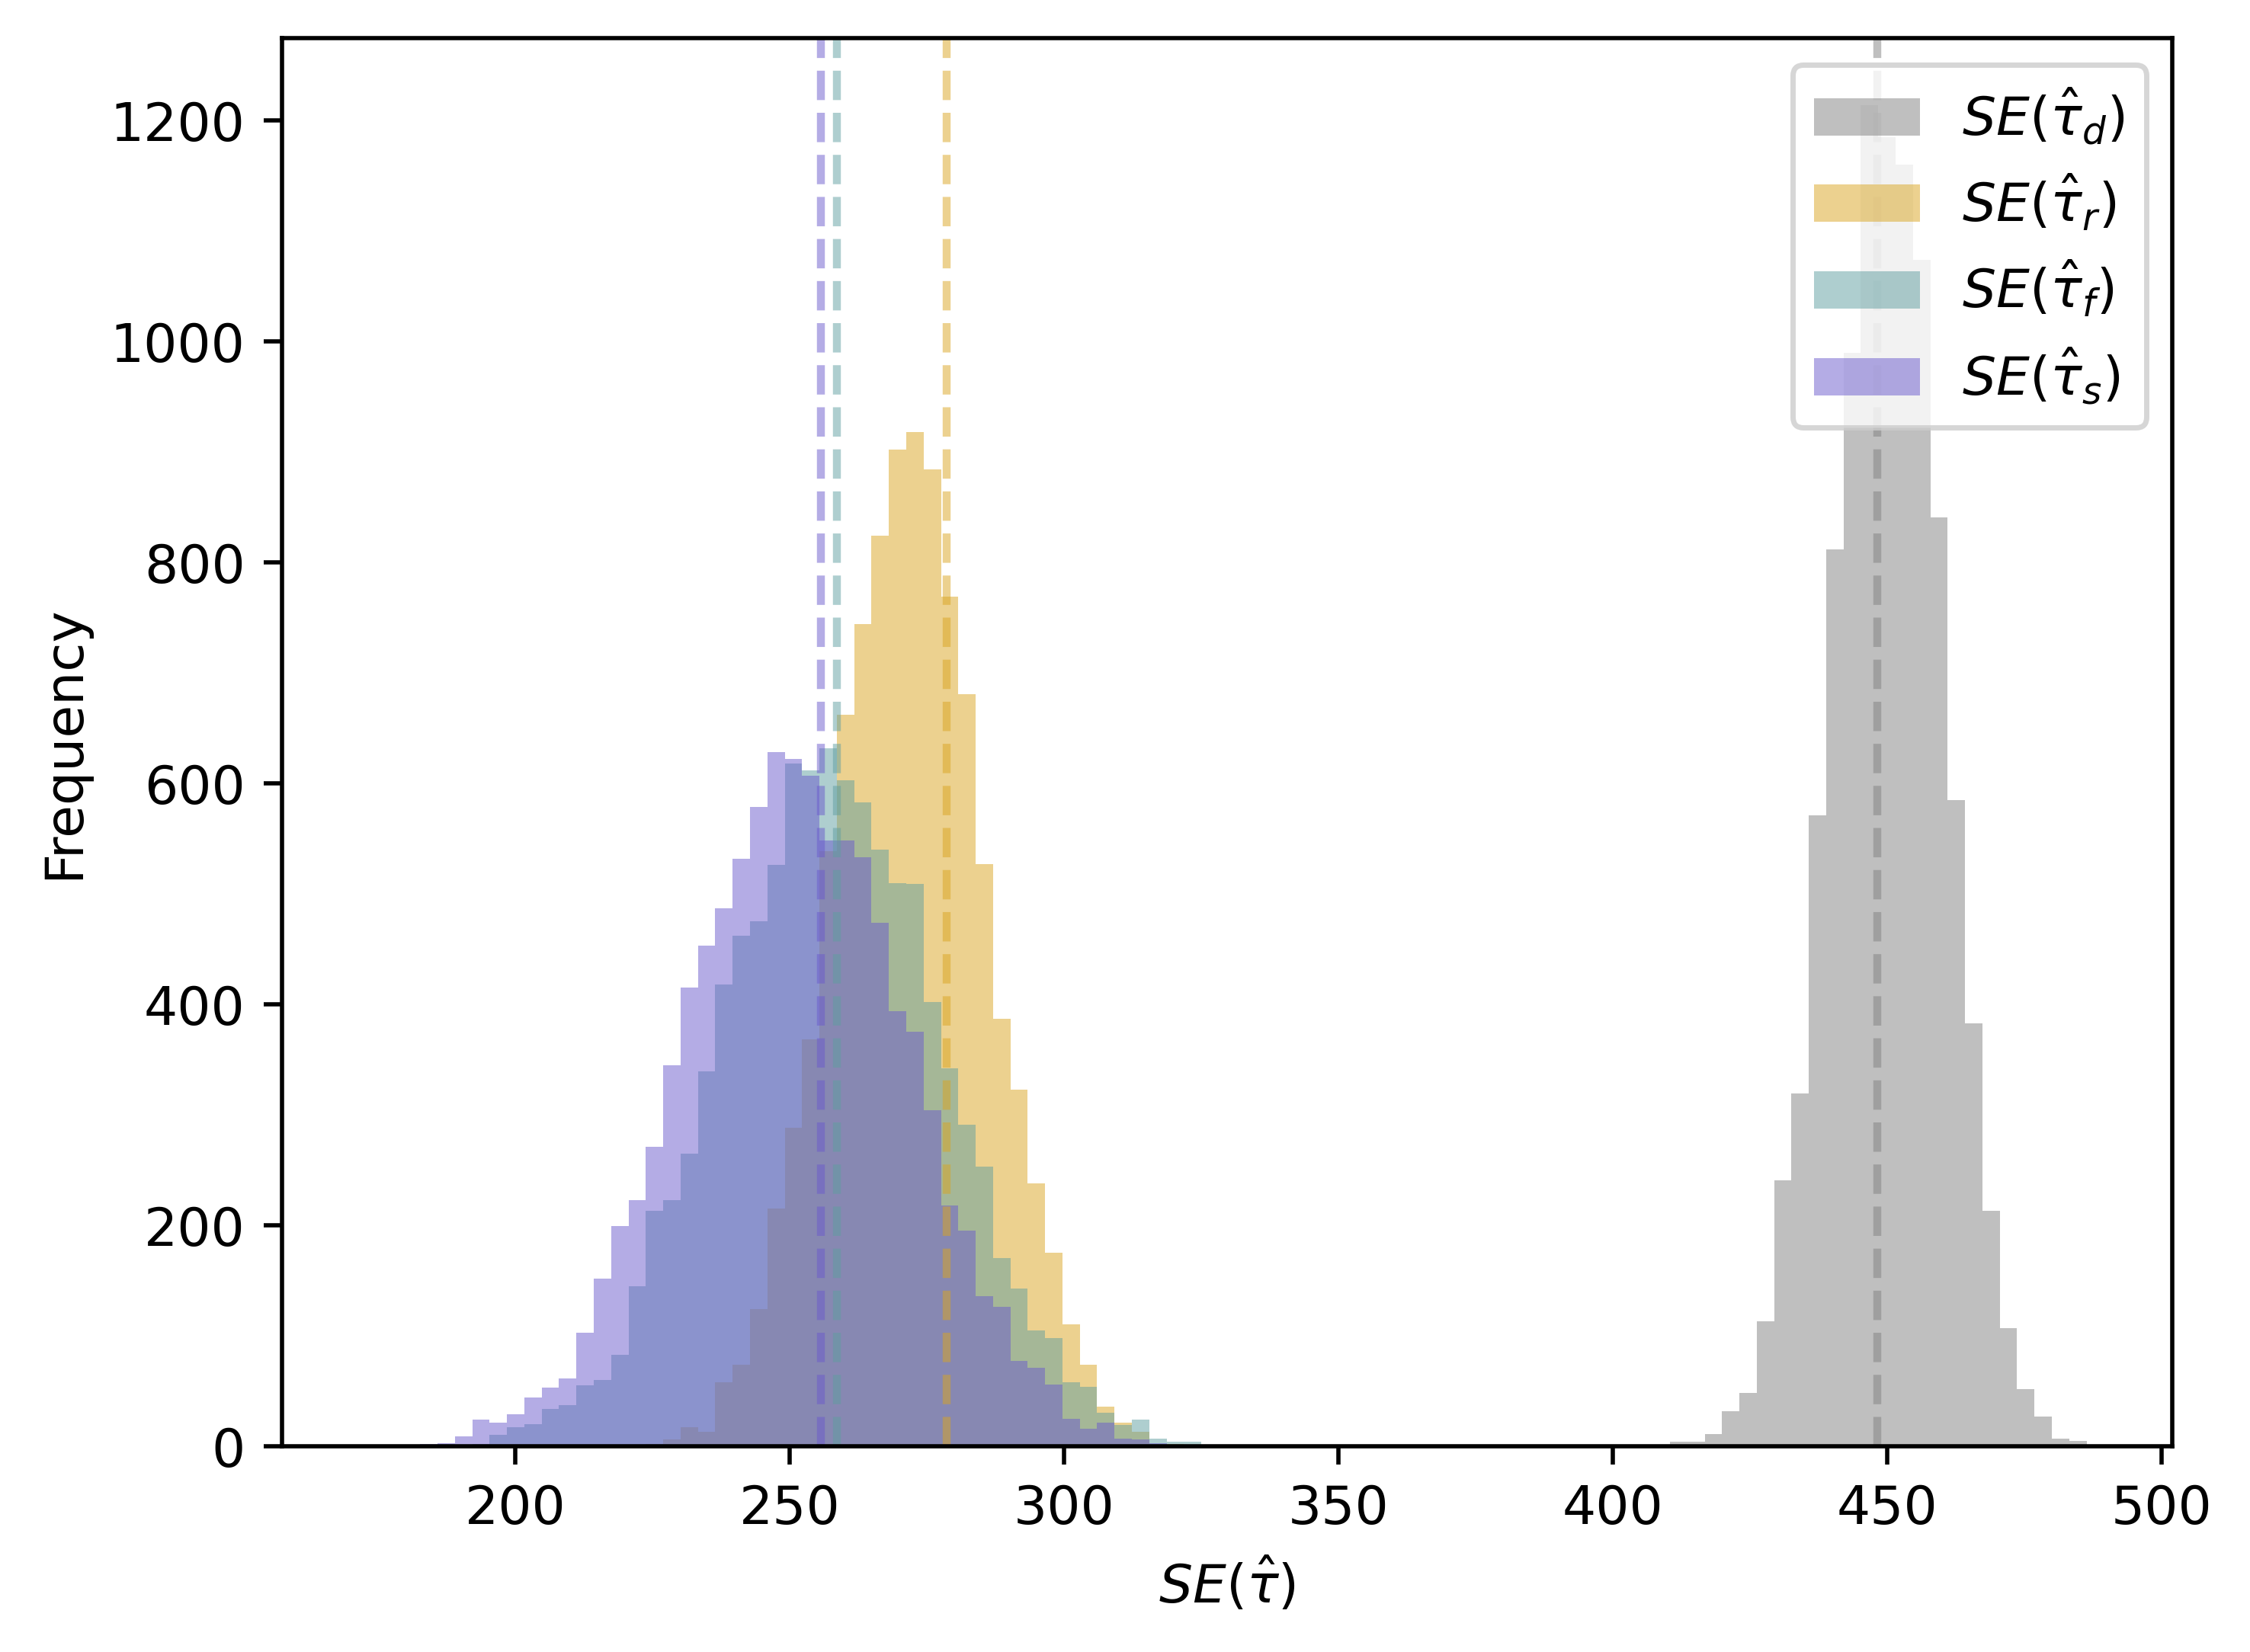

Std_d: 448.2416090045683 Std_r: 278.6112974432273 Std_ml:  258.6845004728476 Std_s: 255.64691007601132 Var_red: 0.42966715953983237


In [50]:
plt.figure(dpi=dpi)
# use this to first determine overall range, and manually set max and min with visual analysis
bins_max = max(max(sim_res['two_se']),max(sim_res['reg_se']),max(sim_res['ml_se']),max(sim_res['s_se']))
bins_min = min(min(sim_res['two_se']),min(sim_res['reg_se']),min(sim_res['ml_se']),min(sim_res['s_se']))
#bins_max = 2
#bins_min = 0.25
bins_freq = 100
bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
plt.hist(sim_res['two_se'], bins = bins_range, color = colors['two'], label = r"$SE(\hat{\tau}_d)$", alpha=0.5)
plt.hist(sim_res['reg_se'], bins = bins_range, color = colors['reg'], label=r"$SE(\hat{\tau}_r)$",alpha=0.5)
plt.hist(sim_res['ml_se'], bins = bins_range, color = colors['ml'], label=r"$SE(\hat{\tau}_{f})$",alpha=0.5)
plt.hist(sim_res['s_se'], bins = bins_range, color = colors['mix'], label=r"$SE(\hat{\tau}_{s})$",alpha=0.5)
plt.axvline(np.std(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
plt.axvline(np.std(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
plt.axvline(np.std(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
plt.axvline(np.std(sim_res['s_est']), color = colors['mix'], linestyle='--',alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel(r"$SE(\hat{\tau})$")
plt.legend(loc=1)
#plt.savefig("plots/sec_" + str(key) + "_se.png")
plt.show()
print("Std_d:", np.std(sim_res['two_est'],ddof=1), "Std_r:", np.std(sim_res['reg_est'],ddof=1), "Std_ml: ", np.std(sim_res['ml_est'],ddof=1),
      "Std_s:", np.std(sim_res['s_est'],ddof=1),"Var_red:", 1-np.std(sim_res['s_est'],ddof=1)/np.std(sim_res['two_est'],ddof=1))

Not too impressive result, and a few reasons for this:
- High dimensional covariate. Covariates are too high dimensional but we have not enough sample for in-experiment data to cover its diversity. The method relies on the assumption that asymptotically, the distribution of covariates converge. However, with high dimensional covariates and small in-experiment data size, it becomes very difficult for them to converge. So, ignoring the extra terms in variance equation is not really appropriate because they don't approach 0 quickly, hence the underestimation of variance by the se estimates compared to the actual standard deviation of TE estimates.
- the pre- and in-experiment data are systematically equivalent. The dataset was randomly split to train/test set, which means they both follow the same distribution. Then our new method of secondary adjustment don't really have an advantage, especially when the ML model of choice (XGboost) is flexible enough to model much of the relationship between covariates and outcome. Beta_s is much smaller than beta in terms of how much covariates impact the outcome. 

In [57]:
sim_res['beta'].mean(), sim_res['beta_s'].mean()

(array([  325.82309784,   155.43734118,  -378.65554456,  8210.16965631,
         2547.02378464,   -42.47690396,    81.64351456,  -349.65087516,
         4266.64031651, -1082.31001316]),
 array([ 2.89239968e+01,  8.29135544e+02, -3.25416019e+02, -6.17429106e+02,
         4.33264277e+02,  5.18857016e+00,  9.30565931e-01, -4.55722113e+02,
         1.41980967e+03, -5.58919492e+02]))